<a href="https://colab.research.google.com/github/bugeki/Forecasting_bus_demand_LSTM/blob/main/forecasting_bus_demand_with_LSTM_with_fillna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Forecasting bus demand in Banana Republic municipalities.

The central urban planning commitee of Banana Republic asked you to help them with the forecast of bus demands of municipalities. And they provide a nice dataset to support you (https://pi.works/3w8IJbV). The dataset includes two measurements for an hour for the number of used buses in each municipality, each measurement is timestamped. The dataset format is as follows (comma separated values): MUNICIPALITY_ID, TIMESTAMP, USAGE, TOTAL_CAPACITY where municipality_id is an anonymization to disguise the actual names, timestamp represents the exact time of the measurement, usage is the number of buses in use at the time of measurement and total_capacity represents the total number of buses in the municipality. There are 10 municipalities (ids from 0 to 9), and two measurements for an hour. The committee asks you to forecast the hourly bus usages for next week for each municipality. Hence you can aggregate the two measurements for an hour by taking the max value (sum would not be a nice idea for the obvious reasons) for each hour, and you should model this data with a time series model of your selection. (It would be a nice idea to implement a very simple baseline model first, and then try to improve the accuracy by introducing more complex methods eventually. The bare minimum requirement of the task is one simple baseline and one complex method.) The committee says that they will use the last two weeks (starting from 2017-08-05 to 2017-08-19) as assessment (test) data, hence your code should report the error (in the criterion you chose for the task) for the last two weeks. You may use true values for the prediction of the last week of test data, then combine the error of the first and last week of the test separately. Keep in mind that the dataset has missing data, hence a suitable missing data interpolation would be useful.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")

plt.rcParams["figure.figsize"] = (10,6)

sns.set_style("whitegrid")
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Set it None to display all rows in the dataframe
# pd.set_option('display.max_rows', None)

# Set it to None to display all columns in the dataframe
pd.set_option('display.max_columns', None)

In [ ]:
!pip install colorama
import colorama
from colorama import Fore, Style  # makes strings colored
!pip3 install termcolor
from termcolor import colored

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Recognizing and Understanding Data

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DL/RNN/municipality_bus_utilization.csv')

In [ ]:
df.head()

,timestamp,municipality_id,usage,total_capacity
0,2017-06-04 07:59:42,9,454,1332
1,2017-06-04 07:59:42,8,556,2947
2,2017-06-04 07:59:42,4,1090,3893
3,2017-06-04 07:59:42,0,204,2813
4,2017-06-04 07:59:42,7,718,2019


In [ ]:
def missing(df):
    missing_number = df.isnull().sum().sort_values(ascending=False)
    missing_percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_values = pd.concat([missing_number, missing_percent], axis=1, keys=['Missing_Number', 'Missing_Percent'])
    return missing_values

def missing_values(df):
    return missing(df)[missing(df)['Missing_Number']>0]
    
def first_looking(df):
    print(colored("Shape:", attrs=['bold']), df.shape,'\n',
          f"There is ", df.shape[0], " observation and ", df.shape[1], " columns in the dataset.", '\n',
          colored('-'*79, 'magenta', attrs=['bold']),
          colored("\nInfo:\n", attrs=['bold']), sep='')
    print(df.info(), '\n', 
          colored('-'*79, 'magenta', attrs=['bold']), sep='')
    print(colored("Number of Uniques:\n", attrs=['bold']), df.nunique(),'\n',
          colored('-'*79, 'magenta', attrs=['bold']), sep='')
    print(colored("Missing Values:\n", attrs=['bold']), missing_values(df),'\n', 
          colored('-'*79, 'magenta', attrs=['bold']), sep='')
    print(colored("All Columns:", attrs=['bold']), list(df.columns),'\n', 
          colored('-'*79, 'magenta', attrs=['bold']), sep='')

    df.columns= df.columns.str.lower().str.replace('&', '_').str.replace(' ', '_')

    print(colored("Columns after rename:", attrs=['bold']), list(df.columns),'\n',
              colored('-'*79, 'magenta', attrs=['bold']), sep='')

def first_looking_col(col):
    print("column name    : ", col)
    print("--------------------------------")
    print("per_of_nulls   : ", "%", round(df[col].isnull().sum()/df.shape[0]*100, 2))
    print("num_of_nulls   : ", df[col].isnull().sum())
    print("num_of_uniques : ", df[col].nunique())
    print(df[col].value_counts(dropna = False)) 

In [ ]:
first_looking(df)

Shape:(13070, 4)
There is 13070 observation and 4 columns in the dataset.
-------------------------------------------------------------------------------
Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13070 entries, 0 to 13069
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   timestamp        13070 non-null  object
 1   municipality_id  13070 non-null  int64 
 2   usage            13070 non-null  int64 
 3   total_capacity   13070 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 408.6+ KB
None
-------------------------------------------------------------------------------
Number of Uniques:
timestamp          1309
municipality_id      10
usage              2346
total_capacity       10
dtype: int64
-------------------------------------------------------------------------------
Missing Values:
Empty DataFrame
Columns: [Missing_Number, Missing_Percent]
Index: []
-------------------------------

In [ ]:
df.isnull().sum()

timestamp          0
municipality_id    0
usage              0
total_capacity     0
dtype: int64

In [ ]:
first_looking_col("usage")

column name    :  usage
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  2346
411     69
354     62
399     31
410     28
623     27
        ..
2830     1
2783     1
2664     1
2463     1
1680     1
Name: usage, Length: 2346, dtype: int64


In [ ]:
df.duplicated().value_counts()

False    13070
dtype: int64

In [ ]:
# convert the timestamp column to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

### Hourly max value

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13070 entries, 0 to 13069
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   timestamp        13070 non-null  datetime64[ns]
 1   municipality_id  13070 non-null  int64         
 2   usage            13070 non-null  int64         
 3   total_capacity   13070 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 408.6 KB


In [ ]:
#dfm = df.groupby([pd.Grouper(key='timestamp', freq='H'), 'municipality_id'], as_index=False)['usage'].max()
dfm = df.groupby([pd.Grouper(key='timestamp', freq='H')])['usage'].max()

In [ ]:
dfm

timestamp
2017-06-04 07:00:00   1090.000
2017-06-04 08:00:00   2016.000
2017-06-04 09:00:00   2811.000
2017-06-04 10:00:00   3178.000
2017-06-04 11:00:00   3257.000
                        ...   
2017-08-19 12:00:00   3157.000
2017-08-19 13:00:00   3194.000
2017-08-19 14:00:00   3183.000
2017-08-19 15:00:00   3111.000
2017-08-19 16:00:00   2779.000
Freq: H, Name: usage, Length: 1834, dtype: float64

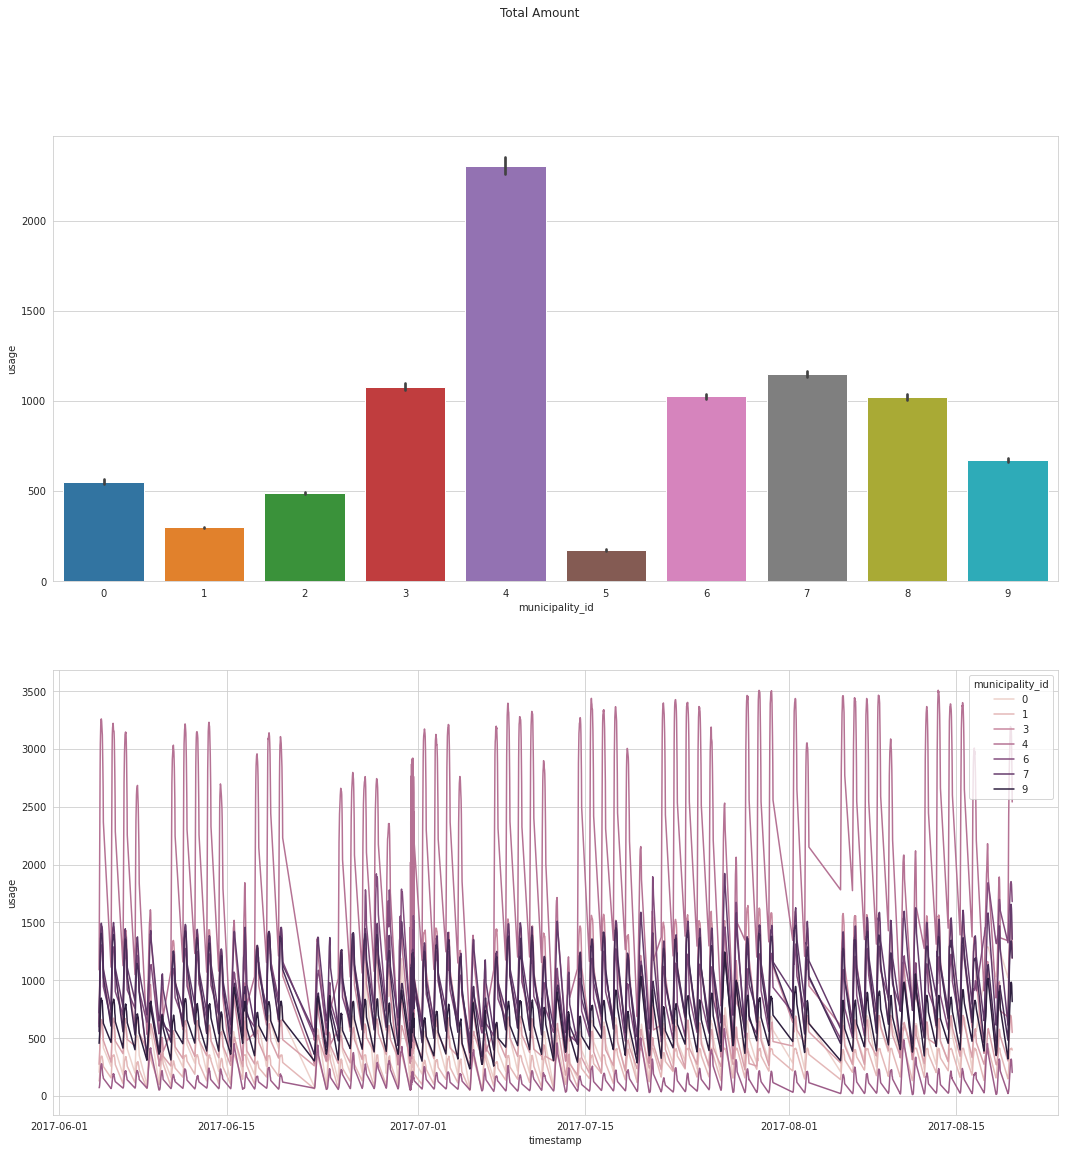

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(18,18))
s = sns.barplot(ax = ax1, x="municipality_id", y="usage", data=df)
s = sns.lineplot(ax = ax2, x='timestamp', y="usage", data=df, color="red", hue='municipality_id')
plt.suptitle("Total Amount")
plt.show();

In [ ]:
df.tail()

,timestamp,municipality_id,usage,total_capacity
13065,2017-08-19 16:30:35,2,548,697
13066,2017-08-19 16:30:35,8,1193,2947
13067,2017-08-19 16:30:35,7,1354,2019
13068,2017-08-19 16:30:35,6,1680,3113
13069,2017-08-19 16:30:35,3,1189,1930


### Separating municipalities

In [ ]:
muni_id=list(df['municipality_id'].unique())

In [ ]:
muni_id.sort()

In [ ]:
muni_id

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [ ]:
d = {i: df[df['municipality_id'] == i] for i in muni_id}

In [ ]:
%%script echo skipping
df1=d[1]
df2=d[2]
df3=d[3]
df4=d[4]
df5=d[5]
df6=d[6]
df7=d[7]
df8=d[8]
df9=d[9]


skipping


###df0

In [ ]:
df0=d[0]

In [ ]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1307 entries, 3 to 13062
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   timestamp        1307 non-null   datetime64[ns]
 1   municipality_id  1307 non-null   int64         
 2   usage            1307 non-null   int64         
 3   total_capacity   1307 non-null   int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 51.1 KB


In [ ]:
df0.head()

,timestamp,municipality_id,usage,total_capacity
3,2017-06-04 07:59:42,0,204,2813
18,2017-06-04 08:25:42,0,247,2813
29,2017-06-04 08:59:42,0,332,2813
34,2017-06-04 09:32:46,0,429,2813
47,2017-06-04 09:59:48,0,485,2813


In [ ]:
df00=df0

In [ ]:
df0=df00

In [ ]:
df00

,timestamp,municipality_id,usage,total_capacity
3,2017-06-04 07:59:42,0,204,2813
18,2017-06-04 08:25:42,0,247,2813
29,2017-06-04 08:59:42,0,332,2813
34,2017-06-04 09:32:46,0,429,2813
47,2017-06-04 09:59:48,0,485,2813
...,...,...,...,...
13024,2017-08-19 14:30:33,0,1285,2813
13031,2017-08-19 15:03:34,0,1283,2813
13041,2017-08-19 15:29:33,0,1286,2813
13059,2017-08-19 16:03:35,0,1276,2813


In [ ]:
df0max=df0.set_index('timestamp')

In [ ]:
df0max= df0.resample('H', on='timestamp').max()

In [ ]:
df0max['year'] = df0max.index.year
df0max['month'] = df0max.index.month
df0max['day'] = df0max.index.day
df0max['hour'] = df0max.index.hour

In [ ]:
df0max.head(20)

,timestamp,municipality_id,usage,total_capacity,year,month,day,hour
timestamp,,,,,,,,
2017-06-04 07:00:00,2017-06-04 07:59:42,0.000,204.000,2813.000,2017,6,4,7
2017-06-04 08:00:00,2017-06-04 08:59:42,0.000,332.000,2813.000,2017,6,4,8
2017-06-04 09:00:00,2017-06-04 09:59:48,0.000,485.000,2813.000,2017,6,4,9
2017-06-04 10:00:00,2017-06-04 10:59:48,0.000,583.000,2813.000,2017,6,4,10
2017-06-04 11:00:00,2017-06-04 11:59:44,0.000,614.000,2813.000,2017,6,4,11
2017-06-04 12:00:00,2017-06-04 12:29:45,0.000,613.000,2813.000,2017,6,4,12
2017-06-04 13:00:00,2017-06-04 13:29:45,0.000,605.000,2813.000,2017,6,4,13
2017-06-04 14:00:00,2017-06-04 14:57:13,0.000,585.000,2813.000,2017,6,4,14
2017-06-04 15:00:00,2017-06-04 15:30:14,0.000,520.000,2813.000,2017,6,4,15


In [ ]:
df0max.groupby(['hour']).count()

,timestamp,municipality_id,usage,total_capacity,year,month,day
hour,,,,,,,
0,0,0,0,0,76,76,76
1,0,0,0,0,76,76,76
2,0,0,0,0,76,76,76
3,0,0,0,0,76,76,76
4,0,0,0,0,76,76,76
5,0,0,0,0,76,76,76
6,0,0,0,0,76,76,76
7,26,26,26,26,77,77,77
8,72,72,72,72,77,77,77


In [ ]:
df0max.head(20)

,timestamp,municipality_id,usage,total_capacity,year,month,day,hour
timestamp,,,,,,,,
2017-06-04 07:00:00,2017-06-04 07:59:42,0.000,204.000,2813.000,2017,6,4,7
2017-06-04 08:00:00,2017-06-04 08:59:42,0.000,332.000,2813.000,2017,6,4,8
2017-06-04 09:00:00,2017-06-04 09:59:48,0.000,485.000,2813.000,2017,6,4,9
2017-06-04 10:00:00,2017-06-04 10:59:48,0.000,583.000,2813.000,2017,6,4,10
2017-06-04 11:00:00,2017-06-04 11:59:44,0.000,614.000,2813.000,2017,6,4,11
2017-06-04 12:00:00,2017-06-04 12:29:45,0.000,613.000,2813.000,2017,6,4,12
2017-06-04 13:00:00,2017-06-04 13:29:45,0.000,605.000,2813.000,2017,6,4,13
2017-06-04 14:00:00,2017-06-04 14:57:13,0.000,585.000,2813.000,2017,6,4,14
2017-06-04 15:00:00,2017-06-04 15:30:14,0.000,520.000,2813.000,2017,6,4,15


In [ ]:
df0max=df0max[(df0max.hour >= 7)&(df0max.hour <= 16)]

In [ ]:
df0max.tail(50)

,timestamp,municipality_id,usage,total_capacity,year,month,day,hour
timestamp,,,,,,,,
2017-08-15 07:00:00,2017-08-15 07:57:02,0.000,229.000,2813.000,2017,8,15,7
2017-08-15 08:00:00,2017-08-15 08:30:06,0.000,311.000,2813.000,2017,8,15,8
2017-08-15 09:00:00,2017-08-15 09:57:02,0.000,489.000,2813.000,2017,8,15,9
2017-08-15 10:00:00,2017-08-15 10:30:07,0.000,542.000,2813.000,2017,8,15,10
2017-08-15 11:00:00,2017-08-15 11:26:03,0.000,637.000,2813.000,2017,8,15,11
2017-08-15 12:00:00,2017-08-15 12:26:03,0.000,678.000,2813.000,2017,8,15,12
2017-08-15 13:00:00,2017-08-15 13:26:08,0.000,692.000,2813.000,2017,8,15,13
2017-08-15 14:00:00,2017-08-15 14:26:06,0.000,685.000,2813.000,2017,8,15,14
2017-08-15 15:00:00,2017-08-15 15:26:03,0.000,674.000,2813.000,2017,8,15,15


In [ ]:
dffill=df0max.fillna(method="bfill")

In [ ]:
dffill.isnull().sum()

timestamp          0
municipality_id    0
usage              0
total_capacity     0
year               0
month              0
day                0
hour               0
dtype: int64

In [ ]:
df0max.isnull().sum()

timestamp          96
municipality_id    96
usage              96
total_capacity     96
year                0
month               0
day                 0
hour                0
dtype: int64

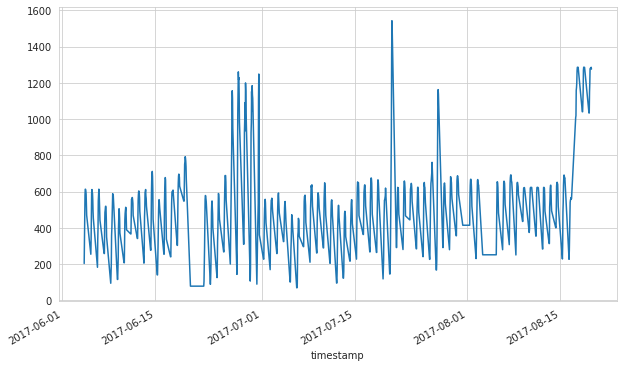

In [ ]:
dffill.usage.plot()

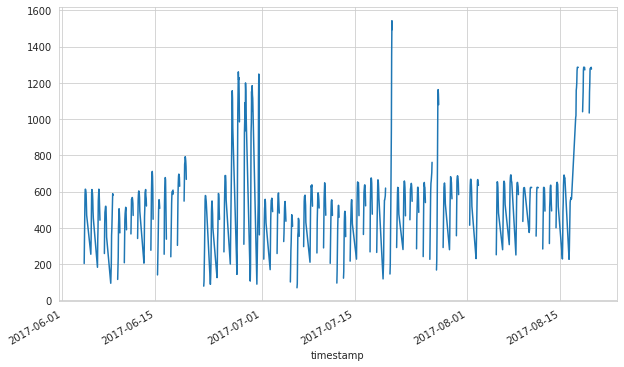

In [ ]:
df0max.usage.plot()

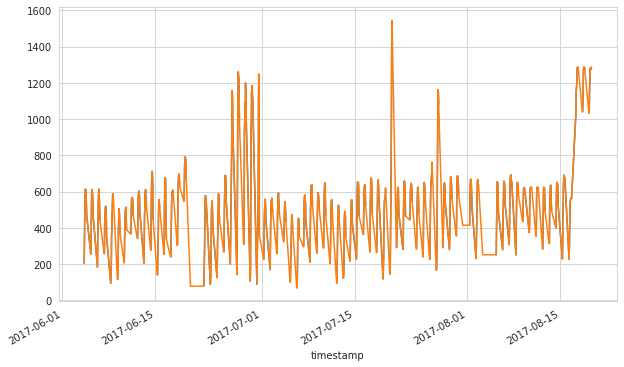

In [ ]:
fig, ax = plt.subplots()
df0max.usage.plot()
dffill.usage.plot()

In [ ]:
df0max=df0max.usage

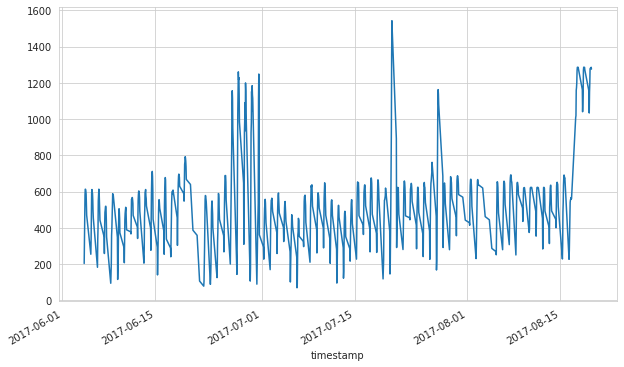

In [ ]:
df0max.interpolate().plot()

In [ ]:
df0int=df0max.interpolate() 

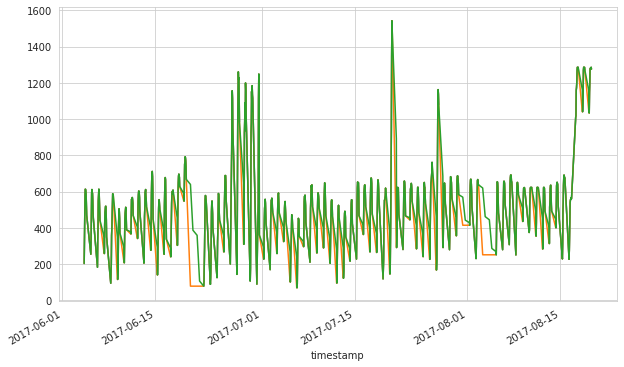

In [ ]:
fig, ax = plt.subplots()
df0max.plot()
dffill.usage.plot()
df0int.plot()

In [ ]:
df0 =dffill.usage

In [ ]:
df0=pd.DataFrame(df0)

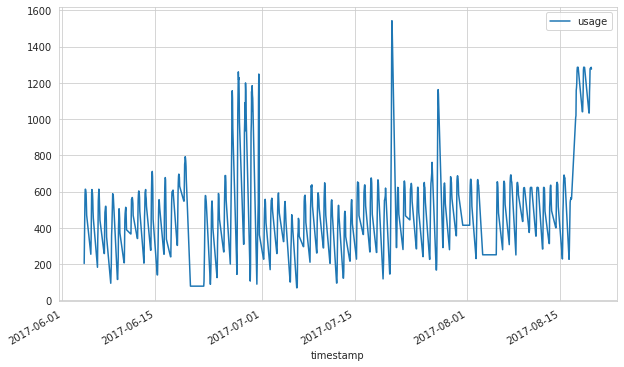

In [ ]:
df0.plot()

# Preprocessing of Data

## Train Test Split

In [ ]:
df0.loc['2017-08-05 07:00:00':] 

,usage
timestamp,
2017-08-05 07:00:00,252.000
2017-08-05 08:00:00,252.000
2017-08-05 09:00:00,393.000
2017-08-05 10:00:00,517.000
2017-08-05 11:00:00,653.000
...,...
2017-08-19 12:00:00,1281.000
2017-08-19 13:00:00,1283.000
2017-08-19 14:00:00,1285.000


In [ ]:
df0.shape

(770, 1)

In [ ]:
df0.loc['2017-08-05 07:00:00':]   # 2 weeks test data

,usage
timestamp,
2017-08-05 07:00:00,252.000
2017-08-05 08:00:00,252.000
2017-08-05 09:00:00,393.000
2017-08-05 10:00:00,517.000
2017-08-05 11:00:00,653.000
...,...
2017-08-19 12:00:00,1281.000
2017-08-19 13:00:00,1283.000
2017-08-19 14:00:00,1285.000


In [ ]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 770 entries, 2017-06-04 07:00:00 to 2017-08-19 16:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   usage   770 non-null    float64
dtypes: float64(1)
memory usage: 28.2 KB


In [ ]:
train, test = df0.loc[:'2017-08-05 07:00:00'], df0.loc['2017-08-05 07:00:00':]
print(len(train), len(test))

621 150


In [ ]:
train

,usage
timestamp,
2017-06-04 07:00:00,204.000
2017-06-04 08:00:00,332.000
2017-06-04 09:00:00,485.000
2017-06-04 10:00:00,583.000
2017-06-04 11:00:00,614.000
...,...
2017-08-04 13:00:00,252.000
2017-08-04 14:00:00,252.000
2017-08-04 15:00:00,252.000


In [ ]:
test

,usage
timestamp,
2017-08-05 07:00:00,252.000
2017-08-05 08:00:00,252.000
2017-08-05 09:00:00,393.000
2017-08-05 10:00:00,517.000
2017-08-05 11:00:00,653.000
...,...
2017-08-19 12:00:00,1281.000
2017-08-19 13:00:00,1283.000
2017-08-19 14:00:00,1285.000


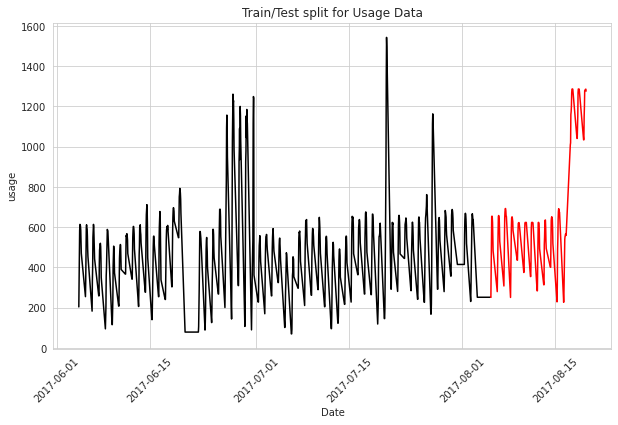

In [ ]:
plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.ylabel('usage')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for Usage Data")
plt.show()

## Scaling

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler = MinMaxScaler()

In [ ]:
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

## Time Series Generator

In [ ]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [ ]:
# help(TimeseriesGenerator)

In [ ]:
length = 10             ### seasonity 
batch_size = 10         
generator = TimeseriesGenerator(train_scaled, train_scaled, length = length, batch_size = batch_size)
validation_generator = TimeseriesGenerator(test_scaled, test_scaled, length = length, batch_size = batch_size)

In [ ]:
len(generator)

62

In [ ]:
generator[0]

(array([[[0.09097081],
         [0.1778683 ],
         [0.28173795],
         [0.34826884],
         [0.36931432],
         [0.36863544],
         [0.36320434],
         [0.34962661],
         [0.30549898],
         [0.27155465]],
 
        [[0.1778683 ],
         [0.28173795],
         [0.34826884],
         [0.36931432],
         [0.36863544],
         [0.36320434],
         [0.34962661],
         [0.30549898],
         [0.27155465],
         [0.12559403]],
 
        [[0.28173795],
         [0.34826884],
         [0.36931432],
         [0.36863544],
         [0.36320434],
         [0.34962661],
         [0.30549898],
         [0.27155465],
         [0.12559403],
         [0.17990496]],
 
        [[0.34826884],
         [0.36931432],
         [0.36863544],
         [0.36320434],
         [0.34962661],
         [0.30549898],
         [0.27155465],
         [0.12559403],
         [0.17990496],
         [0.28309572]],
 
        [[0.36931432],
         [0.36863544],
         [0.36320434],

In [ ]:
X, y = generator[0]

In [ ]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.09097081 0.1778683  0.28173795 0.34826884 0.36931432 0.36863544
 0.36320434 0.34962661 0.30549898 0.27155465 0.1778683  0.28173795
 0.34826884 0.36931432 0.36863544 0.36320434 0.34962661 0.30549898
 0.27155465 0.12559403 0.28173795 0.34826884 0.36931432 0.36863544
 0.36320434 0.34962661 0.30549898 0.27155465 0.12559403 0.17990496
 0.34826884 0.36931432 0.36863544 0.36320434 0.34962661 0.30549898
 0.27155465 0.12559403 0.17990496 0.28309572 0.36931432 0.36863544
 0.36320434 0.34962661 0.30549898 0.27155465 0.12559403 0.17990496
 0.28309572 0.35641548 0.36863544 0.36320434 0.34962661 0.30549898
 0.27155465 0.12559403 0.17990496 0.28309572 0.35641548 0.36795655
 0.36320434 0.34962661 0.30549898 0.27155465 0.12559403 0.17990496
 0.28309572 0.35641548 0.36795655 0.35641548 0.34962661 0.30549898
 0.27155465 0.12559403 0.17990496 0.28309572 0.35641548 0.36795655
 0.35641548 0.35437882 0.30549898 0.27155465 0.12559403 0.17990496
 0.28309572 0.35641548 0.36795655 0.35641548

# Modelling

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Dropout

In [ ]:
train_scaled.shape

(621, 1)

In [ ]:
n_features = train_scaled.shape[1]

In [ ]:
n_features

1

In [ ]:
model = Sequential()
model.add(LSTM(64, activation = 'relu', return_sequences=True, input_shape = (length, n_features)))
model.add(Dropout(0.2))
model.add(LSTM(32, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 64)            16896     
                                                                 
 dropout (Dropout)           (None, 10, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 29,345
Trainable params: 29,345
Non-trainable params: 0
_________________________________________________________________


## EarlyStopping and Validation Generator

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 10,restore_best_weights = True)

In [ ]:
len(validation_generator)

14

In [ ]:
model.fit(x = generator,
          epochs = 50,
          validation_data = validation_generator,
          callbacks = [early_stop])

Epoch 1/50
62/62 [==============================] - 7s 47ms/step - loss: 0.0360 - val_loss: 0.0404
Epoch 2/50
62/62 [==============================] - 2s 29ms/step - loss: 0.0248 - val_loss: 0.0197
Epoch 3/50
62/62 [==============================] - 2s 25ms/step - loss: 0.0241 - val_loss: 0.0189
Epoch 4/50
62/62 [==============================] - 2s 26ms/step - loss: 0.0232 - val_loss: 0.0203
Epoch 5/50
62/62 [==============================] - 2s 28ms/step - loss: 0.0218 - val_loss: 0.0134
Epoch 6/50
62/62 [==============================] - 2s 24ms/step - loss: 0.0203 - val_loss: 0.0185
Epoch 7/50
62/62 [==============================] - 2s 27ms/step - loss: 0.0222 - val_loss: 0.0224
Epoch 8/50
62/62 [==============================] - 2s 32ms/step - loss: 0.0184 - val_loss: 0.0310
Epoch 9/50
62/62 [==============================] - 2s 25ms/step - loss: 0.0212 - val_loss: 0.0216
Epoch 10/50
62/62 [==============================] - 1s 14ms/step - loss: 0.0198 - val_loss: 0.0152
Epoch 11/

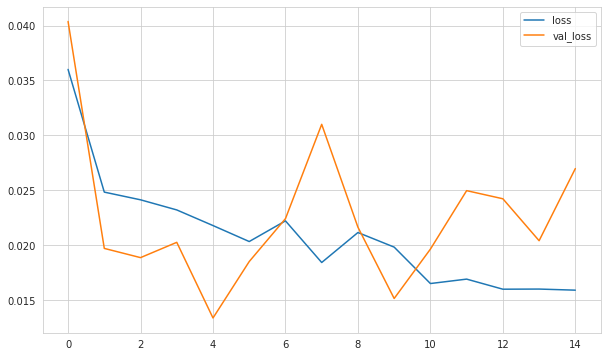

In [ ]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

# Evaluation on Test Data

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    mse = mean_squared_error(actual, pred)
    score = r2_score(actual, pred)
    return print("r2_score:", score, "\nmae:", mae, "\nmse:",mse, "\nrmse:",rmse)

In [ ]:
predictions_scaled = []

first_eval_batch = train_scaled[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(length):
    
    # get prediction 1 time stamp ahead
    current_pred = model.predict(current_batch)
    
    # store prediction
    predictions_scaled.append(current_pred[0]) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [current_pred], axis=1)


In [ ]:
predictions_scaled

[array([0.21178174], dtype=float32),
 array([0.21583498], dtype=float32),
 array([0.22146374], dtype=float32),
 array([0.22786394], dtype=float32),
 array([0.2346681], dtype=float32),
 array([0.24162042], dtype=float32),
 array([0.24871552], dtype=float32),
 array([0.2560223], dtype=float32),
 array([0.2636556], dtype=float32),
 array([0.27421257], dtype=float32)]

In [ ]:
eval_metrics(test_scaled[:length], predictions_scaled)

r2_score: -0.08829576807593997 
mae: 0.09125052936936591 
mse: 0.011180876985154735 
rmse: 0.10573966609156062


## Inverse Transformation and Comparing

In [ ]:
predictions = scaler.inverse_transform(predictions_scaled)

In [ ]:
compare = test[:10]

In [ ]:
compare['Predictions_tanh'] = predictions

In [ ]:
compare

,usage,Predictions_tanh
timestamp,,
2017-08-05 07:00:00,252.000,381.955
2017-08-05 08:00:00,252.000,387.925
2017-08-05 09:00:00,393.000,396.216
2017-08-05 10:00:00,517.000,405.644
2017-08-05 11:00:00,653.000,415.666
2017-08-05 12:00:00,655.000,425.907
2017-08-05 13:00:00,649.000,436.358
2017-08-05 14:00:00,622.000,447.121
2017-08-05 15:00:00,559.000,458.365


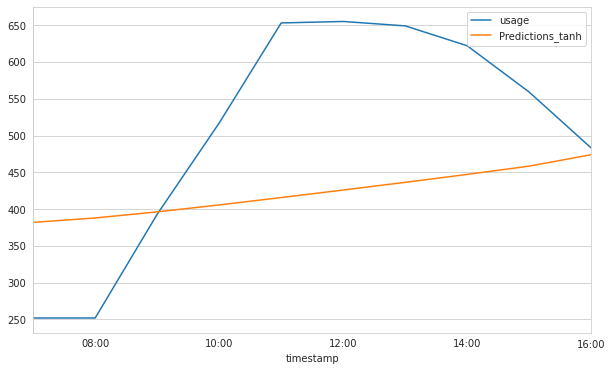

In [ ]:
compare.plot()

In [ ]:
eval_metrics(compare.usage, compare.Predictions_tanh)

r2_score: -0.08829576807593997 
mae: 134.41202976107598 
mse: 24259.473040122797 
rmse: 155.7545281528688


# modelling Bidirectional with "relu" activation function - 2 

In [ ]:
model2 = Sequential()
model2.add(Bidirectional(LSTM(100, activation = 'relu', return_sequences=True, input_shape = (length, n_features))))
model2.add(Dropout(0.2))
model2.add(Bidirectional(LSTM(50, activation = 'relu', return_sequences=True)))
model2.add(Dropout(0.2))
model2.add(Bidirectional(LSTM(20, activation = 'relu')))
model2.add(Dropout(0.2))
model2.add(Dense(1))
model2.compile(optimizer = 'adam', loss = 'mse')

In [ ]:
model2.summary()

ValueError: ignored

In [ ]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True)

In [ ]:
model2.fit_generator(generator,
                    epochs = 50,
                    validation_data = validation_generator,
                    callbacks = [early_stop])

Epoch 1/50
62/62 [==============================] - 11s 54ms/step - loss: 0.0389 - val_loss: 0.0174
Epoch 2/50
62/62 [==============================] - 2s 33ms/step - loss: 0.0260 - val_loss: 0.0173
Epoch 3/50
62/62 [==============================] - 2s 34ms/step - loss: 0.0217 - val_loss: 0.0197
Epoch 4/50
62/62 [==============================] - 2s 34ms/step - loss: 0.0192 - val_loss: 0.0285
Epoch 5/50
62/62 [==============================] - 2s 33ms/step - loss: 0.0179 - val_loss: 0.0107
Epoch 6/50
62/62 [==============================] - 2s 34ms/step - loss: 0.0131 - val_loss: 0.0083
Epoch 7/50
62/62 [==============================] - 2s 34ms/step - loss: 0.0146 - val_loss: 0.0140
Epoch 8/50
62/62 [==============================] - 2s 34ms/step - loss: 0.0120 - val_loss: 0.0160
Epoch 9/50
62/62 [==============================] - 2s 33ms/step - loss: 0.0100 - val_loss: 0.0100
Epoch 10/50
62/62 [==============================] - 2s 34ms/step - loss: 0.0106 - val_loss: 0.0102
Epoch 11

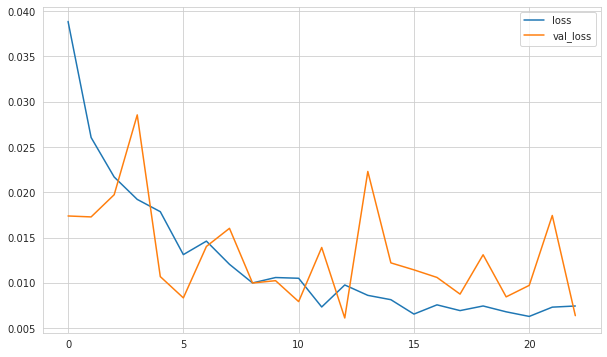

In [ ]:
loss_df = pd.DataFrame(model2.history.history)
loss_df.plot()

###Evaluation on Test Data

In [ ]:
predictions_scaled = []

first_eval_batch = train_scaled[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(length):
    
    # get prediction 1 time stamp ahead
    current_pred = model2.predict(current_batch)
    
    # store prediction
    predictions_scaled.append(current_pred[0]) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [current_pred], axis=1)

###Inverse Transformation and Comparing


In [ ]:
predictions = scaler.inverse_transform(predictions_scaled)


In [ ]:
compare['Predictions_2'] = predictions
compare

,usage,Predictions_tanh,Predictions_2
timestamp,,,
2017-08-05 07:00:00,252.000,381.955,220.622
2017-08-05 08:00:00,252.000,387.925,205.357
2017-08-05 09:00:00,393.000,396.216,195.376
2017-08-05 10:00:00,517.000,405.644,188.000
2017-08-05 11:00:00,653.000,415.666,182.040
2017-08-05 12:00:00,655.000,425.907,177.123
2017-08-05 13:00:00,649.000,436.358,173.211
2017-08-05 14:00:00,622.000,447.121,170.140
2017-08-05 15:00:00,559.000,458.365,167.664


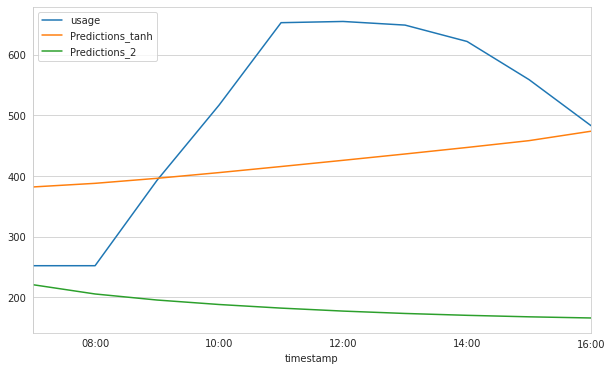

In [ ]:
compare.plot()


In [ ]:
eval_metrics(compare.usage, compare.Predictions_2)


r2_score: -4.764409135363193 
mae: 318.96989580765364 
mse: 128495.88513866479 
rmse: 358.46322703823444


# Retrain and Forecasting

In [ ]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df0)

In [ ]:
length=10
length

10

In [ ]:
batch_size = 1
batch_size

1

In [ ]:
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length = length, batch_size = batch_size)

In [ ]:
len(df0)

770

In [ ]:
len(generator)

760

In [ ]:
model = Sequential()
model.add(LSTM(20, activation = 'relu', return_sequences=True, input_shape = (length, n_features)))
model.add(Dropout(0.2))
model.add(LSTM(10, activation = 'relu', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(5, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

In [ ]:
scaled_full_data.shape

(770, 1)

In [ ]:
scaled_full_data[-length:].shape

(10, 1)

In [ ]:
forecast = []

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(100):
    
    
    current_pred = model.predict(current_batch)

    
    forecast.append(current_pred[0]) 

    
    current_batch = np.append(current_batch[:, 1:, :], [current_pred], axis = 1)


In [ ]:
print(current_pred)

[[2.6979677e-19]]


In [ ]:
print(predictions_scaled)

[array([0.10225527], dtype=float32), array([0.09189199], dtype=float32), array([0.0851164], dtype=float32), array([0.08010843], dtype=float32), array([0.07606237], dtype=float32), array([0.07272461], dtype=float32), array([0.07006844], dtype=float32), array([0.06798352], dtype=float32), array([0.06630295], dtype=float32), array([0.06501558], dtype=float32)]


In [ ]:
print(current_batch)

[[[1.12751674e-17]
  [7.43173142e-18]
  [4.90484230e-18]
  [3.24201592e-18]
  [2.14504187e-18]
  [1.41940026e-18]
  [9.38571132e-19]
  [6.19931182e-19]
  [4.09059890e-19]
  [2.69796770e-19]]]


In [ ]:
forecast = scaler.inverse_transform(forecast)

In [ ]:
forecast

array([[119.57799487],
       [119.59176813],
       [118.16306454],
       [114.89164758],
       [110.33674434],
       [104.64158569],
       [ 98.41885924],
       [ 91.85296336],
       [ 85.11323501],
       [ 78.27191312],
       [ 71.76978731],
       [ 71.56976662],
       [ 71.34131415],
       [ 71.10002951],
       [ 70.86292418],
       [ 70.64371237],
       [ 70.45230254],
       [ 70.29276407],
       [ 70.16922375],
       [ 70.08715666],
       [ 70.04476128],
       [ 70.03590072],
       [ 70.02773176],
       [ 70.02057214],
       [ 70.01458876],
       [ 70.0098648 ],
       [ 70.00631544],
       [ 70.00382289],
       [ 70.00225348],
       [ 70.00136647],
       [ 70.00091335],
       [ 70.000677  ],
       [ 70.00048485],
       [ 70.00033459],
       [ 70.0002226 ],
       [ 70.00014314],
       [ 70.00008955],
       [ 70.0000557 ],
       [ 70.00003546],
       [ 70.00002357],
       [ 70.00001632],
       [ 70.00001142],
       [ 70.00000776],
       [ 70

In [ ]:
df0

,usage
timestamp,
2017-06-04 07:00:00,204.000
2017-06-04 08:00:00,332.000
2017-06-04 09:00:00,485.000
2017-06-04 10:00:00,583.000
2017-06-04 11:00:00,614.000
...,...
2017-08-19 12:00:00,1281.000
2017-08-19 13:00:00,1283.000
2017-08-19 14:00:00,1285.000


### Week before Last Week

In [ ]:
forecast_index = pd.date_range(start = '2017-08-05 07:00:00', periods = 100, freq = 'H')

In [ ]:
forecast_index

DatetimeIndex(['2017-08-05 07:00:00', '2017-08-05 08:00:00',
               '2017-08-05 09:00:00', '2017-08-05 10:00:00',
               '2017-08-05 11:00:00', '2017-08-05 12:00:00',
               '2017-08-05 13:00:00', '2017-08-05 14:00:00',
               '2017-08-05 15:00:00', '2017-08-05 16:00:00',
               '2017-08-05 17:00:00', '2017-08-05 18:00:00',
               '2017-08-05 19:00:00', '2017-08-05 20:00:00',
               '2017-08-05 21:00:00', '2017-08-05 22:00:00',
               '2017-08-05 23:00:00', '2017-08-06 00:00:00',
               '2017-08-06 01:00:00', '2017-08-06 02:00:00',
               '2017-08-06 03:00:00', '2017-08-06 04:00:00',
               '2017-08-06 05:00:00', '2017-08-06 06:00:00',
               '2017-08-06 07:00:00', '2017-08-06 08:00:00',
               '2017-08-06 09:00:00', '2017-08-06 10:00:00',
               '2017-08-06 11:00:00', '2017-08-06 12:00:00',
               '2017-08-06 13:00:00', '2017-08-06 14:00:00',
               '2017-08-

In [ ]:
forecast_df = pd.DataFrame(data = forecast, index = forecast_index, columns = ['Forecast'])

In [ ]:
forecast_df

,Forecast
2017-08-05 07:00:00,119.578
2017-08-05 08:00:00,119.592
2017-08-05 09:00:00,118.163
2017-08-05 10:00:00,114.892
2017-08-05 11:00:00,110.337
...,...
2017-08-09 06:00:00,70.000
2017-08-09 07:00:00,70.000
2017-08-09 08:00:00,70.000
2017-08-09 09:00:00,70.000


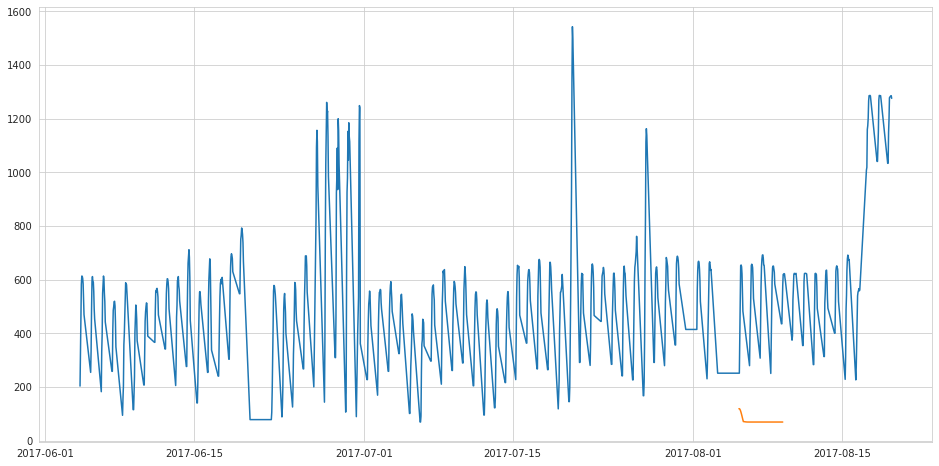

In [ ]:
plt.figure(figsize = (16, 8))
plt.plot(df0.index, df0['usage'])
plt.plot(forecast_df.index, forecast_df['Forecast'])

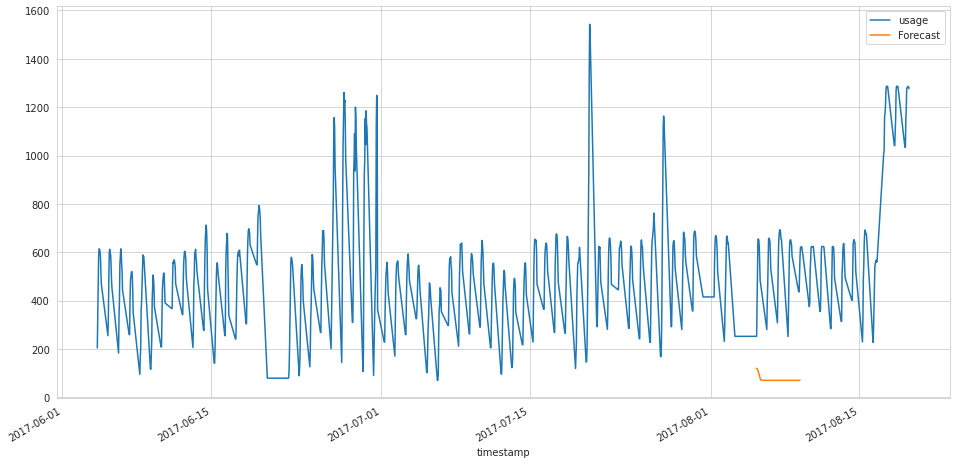

In [ ]:
ax = df0.plot()
forecast_df.plot(ax = ax, figsize = (16, 8));

(736546.2916666666, 736561.2916666666)

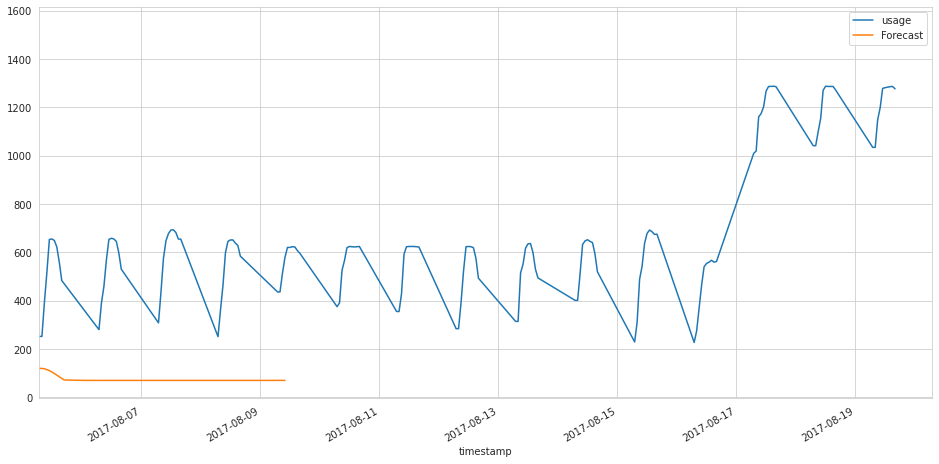

In [ ]:
ax = df0.plot()
forecast_df.plot(ax = ax, figsize = (16, 8))
plt.xlim('2017-08-05 07:00:00', '2017-08-20 07:00:00')

### Last Week

In [ ]:
forecast_index = pd.date_range(start = '2017-08-12 07:00:00', periods = 100, freq = 'H')

In [ ]:
forecast_index

DatetimeIndex(['2017-08-12 07:00:00', '2017-08-12 08:00:00',
               '2017-08-12 09:00:00', '2017-08-12 10:00:00',
               '2017-08-12 11:00:00', '2017-08-12 12:00:00',
               '2017-08-12 13:00:00', '2017-08-12 14:00:00',
               '2017-08-12 15:00:00', '2017-08-12 16:00:00',
               '2017-08-12 17:00:00', '2017-08-12 18:00:00',
               '2017-08-12 19:00:00', '2017-08-12 20:00:00',
               '2017-08-12 21:00:00', '2017-08-12 22:00:00',
               '2017-08-12 23:00:00', '2017-08-13 00:00:00',
               '2017-08-13 01:00:00', '2017-08-13 02:00:00',
               '2017-08-13 03:00:00', '2017-08-13 04:00:00',
               '2017-08-13 05:00:00', '2017-08-13 06:00:00',
               '2017-08-13 07:00:00', '2017-08-13 08:00:00',
               '2017-08-13 09:00:00', '2017-08-13 10:00:00',
               '2017-08-13 11:00:00', '2017-08-13 12:00:00',
               '2017-08-13 13:00:00', '2017-08-13 14:00:00',
               '2017-08-

In [ ]:
forecast_df = pd.DataFrame(data = forecast, index = forecast_index, columns = ['Forecast'])

In [ ]:
forecast_df

,Forecast
2017-08-12 07:00:00,119.578
2017-08-12 08:00:00,119.592
2017-08-12 09:00:00,118.163
2017-08-12 10:00:00,114.892
2017-08-12 11:00:00,110.337
...,...
2017-08-16 06:00:00,70.000
2017-08-16 07:00:00,70.000
2017-08-16 08:00:00,70.000
2017-08-16 09:00:00,70.000


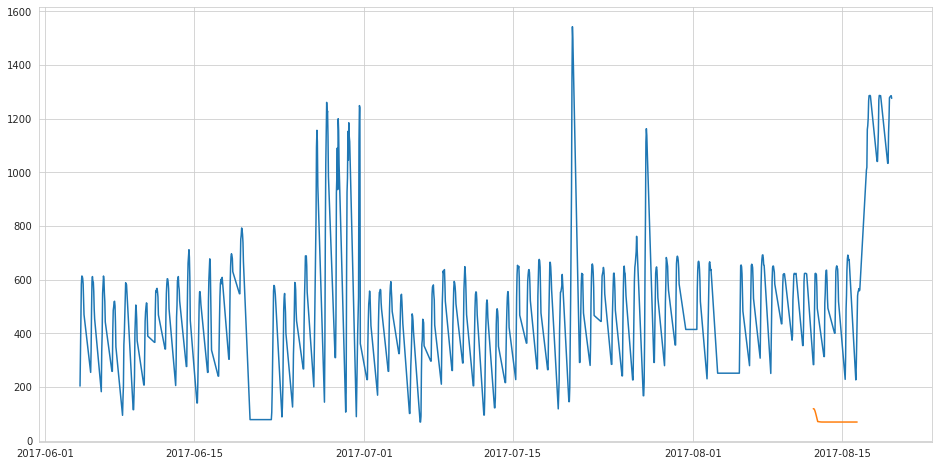

In [ ]:
plt.figure(figsize = (16, 8))
plt.plot(df0.index, df0['usage'])
plt.plot(forecast_df.index, forecast_df['Forecast'])

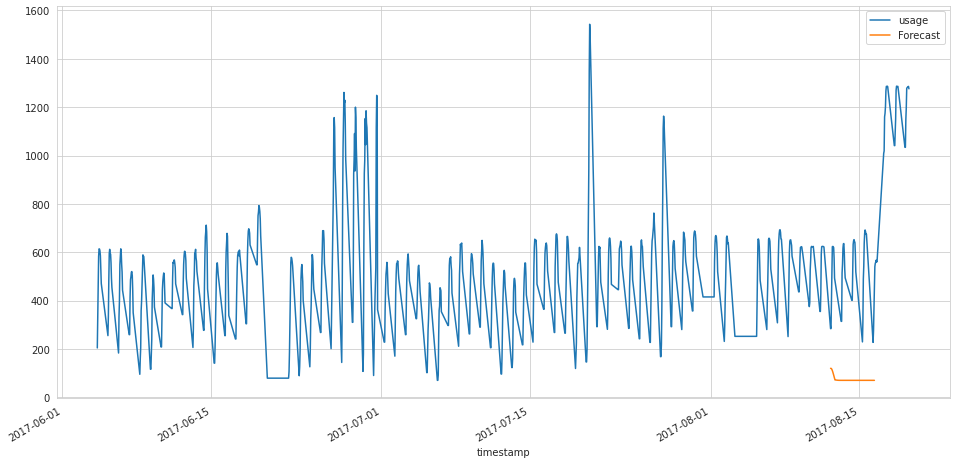

In [ ]:
ax = df0.plot()
forecast_df.plot(ax = ax, figsize = (16, 8));

(736553.2916666666, 736561.0)

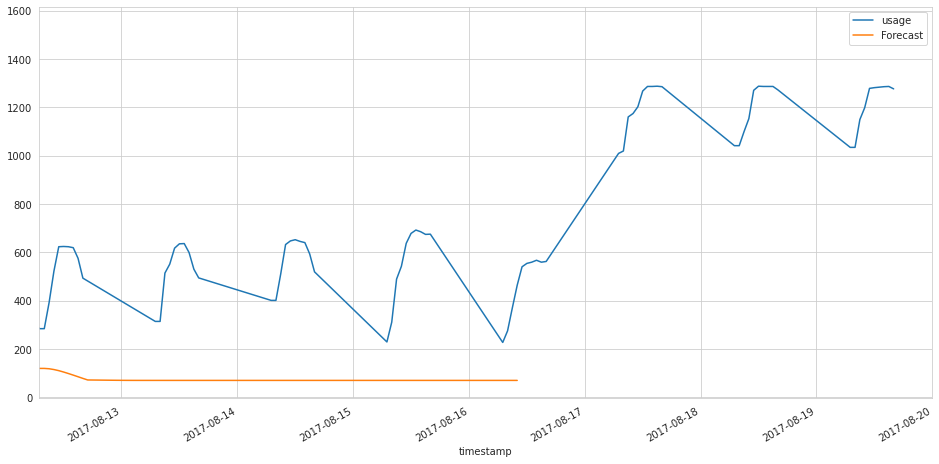

In [ ]:
ax = df0.plot()
forecast_df.plot(ax = ax, figsize = (16, 8))
plt.xlim('2017-08-12 07:00:00', '2017-08-20 00:00:00')